In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf

In [3]:
effr = pd.read_csv('data/EFFR.csv')
effr = effr.rename(columns={'DATE':'Date'})
effr['Date'] = pd.to_datetime(effr['Date'])
effr.head()

,Date,EFFR
0,2006-01-03,4.34
1,2006-01-04,4.22
2,2006-01-05,4.24
3,2006-01-06,4.22
4,2006-01-09,4.25


In [4]:
spy = yf.download(tickers='SPY', start='2006-01-01', end='2023-01-01', interval='1d')
spy['Daily Return'] = (spy['Close'] / spy['Close'].shift(1)) -1
spy['Date'] = pd.to_datetime(spy.index)
spy = spy.assign(Index=range(len(spy))).set_index('Index')
spy.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Daily Return,Date
Index,,,,,,,,
0,125.190002,127.000000,124.389999,126.699997,90.987633,73256700,NaN,2006-01-03
1,126.860001,127.489998,126.699997,127.300003,91.418541,51899600,0.004736,2006-01-04
2,127.150002,127.589996,126.879997,127.379997,91.475960,47307500,0.000628,2006-01-05
3,128.020004,128.580002,127.360001,128.440002,92.237206,62885900,0.008322,2006-01-06
4,128.419998,129.059998,128.380005,128.770004,92.474190,43527400,0.002569,2006-01-09


In [62]:
data = pd.merge(spy, effr)
# data.drop(columns='Open', 'High','Low')
data.to_csv('data/sample_data.csv')

In [63]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Date,EFFR
0,125.190002,127.000000,124.389999,126.699997,90.987648,73256700,NaN,2006-01-03,4.34
1,126.860001,127.489998,126.699997,127.300003,91.418541,51899600,0.004736,2006-01-04,4.22
2,127.150002,127.589996,126.879997,127.379997,91.475983,47307500,0.000628,2006-01-05,4.24
3,128.020004,128.580002,127.360001,128.440002,92.237198,62885900,0.008322,2006-01-06,4.22
4,128.419998,129.059998,128.380005,128.770004,92.474174,43527400,0.002569,2006-01-09,4.25


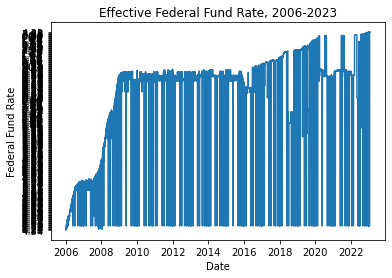

In [8]:
# Create figure and plot space
plt.plot(effr.Date,effr.EFFR)


plt.title('Effective Federal Fund Rate, 2006-2023')
plt.xlabel('Date')
plt.ylabel('Federal Fund Rate')
# plot.figsize((10,6))
plt.savefig('ffer_2003t2023.png')

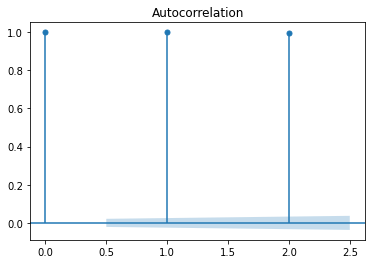

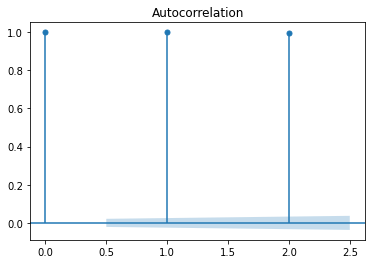

In [8]:
plot_acf(ffer.DFF, lags = 2) 